# Learning with non-classical Logic

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.status()
Pkg.resolve()

  Activating project at `~/.julia/dev/logic-and-machine-learning`


Status `~/.julia/dev/logic-and-machine-learning/Project.toml`
⌃ [da404889] ARFFFiles v1.5.0
  [6e4b80f9] BenchmarkTools v1.6.3
  [861a8166] Combinatorics v1.1.0
  [a93c6f00] DataFrames v1.8.1
  [7806a523] DecisionTree v0.12.4
⌃ [86223c79] Graphs v1.13.1
  [f7bf1975] Impute v0.6.13
⌅ [add582a8] MLJ v0.20.9
⌃ [a7f614a8] MLJBase v1.9.2
⌃ [c6f25543] MLJDecisionTreeInterface v0.4.2
  [b59e7f69] ManyExpertDecisionTrees v1.0.0 `https://github.com/aclai-lab/ManyExpertDecisionTrees.jl#`
  [24e37439] MatrixProfile v1.1.1
  [fb95e5f7] ModalAssociationRules v0.2.1
  [e54bda2e] ModalDecisionTrees v0.5.2
  [91a5bcdd] Plots v1.41.4
  [ce6b1742] RDatasets v0.8.1
  [4475fa32] SoleBase v0.13.4
  [123f1ae1] SoleData v0.16.7
  [b002da8f] SoleLogics v0.13.7
  [4249d9c7] SoleModels v0.10.6
  [cf1aa0c3] SolePostHoc v0.1.0 `https://github.com/aclai-lab/SolePostHoc.jl#ijcai2026_From_forests_to_minimal_formulas#`
  [eb5c4719] SoleReasoners v0.1.0
  [2913bbd2] StatsBase v0.34.9
  [9a3f8284] Random v1.11.0
  [9e8

  No Changes to `~/.julia/dev/logic-and-machine-learning/Project.toml`
  No Changes to `~/.julia/dev/logic-and-machine-learning/Manifest.toml`


In [2]:
using Random
Random.seed!(1605)

TaskLocalRNG()

## Learning with Modal Logic

Let us try to tackle the Natops dataset with what we learned in the previous days.

In [3]:
using ARFFFiles

using DataFrames
using MLJ
using Plots
using Random
using StatsBase
using SoleData
using SoleModels

In [4]:
using SoleData.Artifacts: fillartifacts, load, NatopsLoader
fillartifacts()
# TODO load Natops from the dataset folder, using load_NATOPS
X, y = SoleData.Artifacts.load(NatopsLoader())

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


(360×24 DataFrame
 Row │ X[Hand tip l]                      Y[Hand tip l]                      Z ⋯
     │ Array…                             Array…                             A ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ [-0.547021, -0.549974, -0.542614…  [-1.81259, -1.80956, -1.7999, -1…  [ ⋯
   2 │ [-0.670576, -0.671489, -0.670918…  [-2.10843, -2.10742, -2.10537, -…  [
   3 │ [-0.603845, -0.603817, -0.603069…  [-1.78957, -1.78978, -1.78455, -…  [
   4 │ [-0.658084, -0.658166, -0.665839…  [-1.91881, -1.91936, -1.90749, -…  [
   5 │ [-0.390152, -0.387313, -0.378055…  [-1.76323, -1.76749, -1.77553, -…  [ ⋯
   6 │ [-0.406136, -0.413803, -0.415171…  [-1.70484, -1.70897, -1.71356, -…  [
   7 │ [-0.480803, -0.479998, -0.472593…  [-1.78482, -1.77784, -1.77085, -…  [
   8 │ [-0.575551, -0.575856, -0.575812…  [-2.08376, -2.08406, -2.07242, -…  [
  ⋮  │                 ⋮                                  ⋮                    ⋱
 354 │ [-0.589451, -0.

In [5]:
X_ninstances, X_nattributes = size(X)
X_ndatapoints = length(X[1,1])

println("Number of instances: $(X_ninstances)")
println("Number of attributes: $(X_nattributes)")
println("Number of datapoints for each attribute: $(X_ndatapoints)")

Number of instances: 360
Number of attributes: 24
Number of datapoints for each attribute: 51


In [6]:
# for every combination of instance and attributes,
# we are still dealing with the same number of datapoints (51)
all(
    i -> length(X[i[1],i[2]]) == X_ndatapoints, 
    Iterators.product(1:X_ninstances, 1:X_nattributes)
)

true

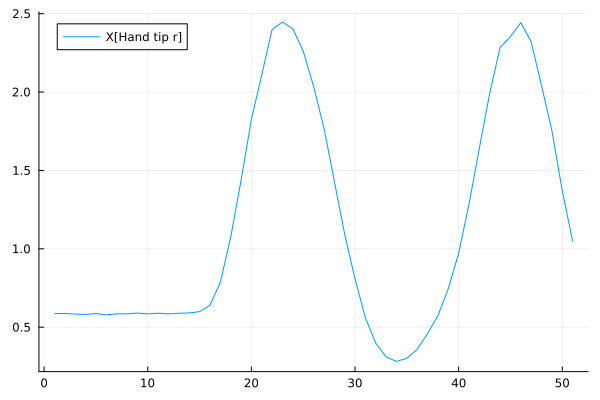

In [7]:
# try to change the target attribute
_attribute = 4
plot(X[1,_attribute], label = names(X)[_attribute])

In [8]:
countmap(y)

Dict{CategoricalArrays.CategoricalValue{String, UInt32}, Int64} with 6 entries:
  "Spread wings"   => 60
  "I have command" => 60
  "Not clear"      => 60
  "Lock wings"     => 60
  "All clear"      => 60
  "Fold wings"     => 60

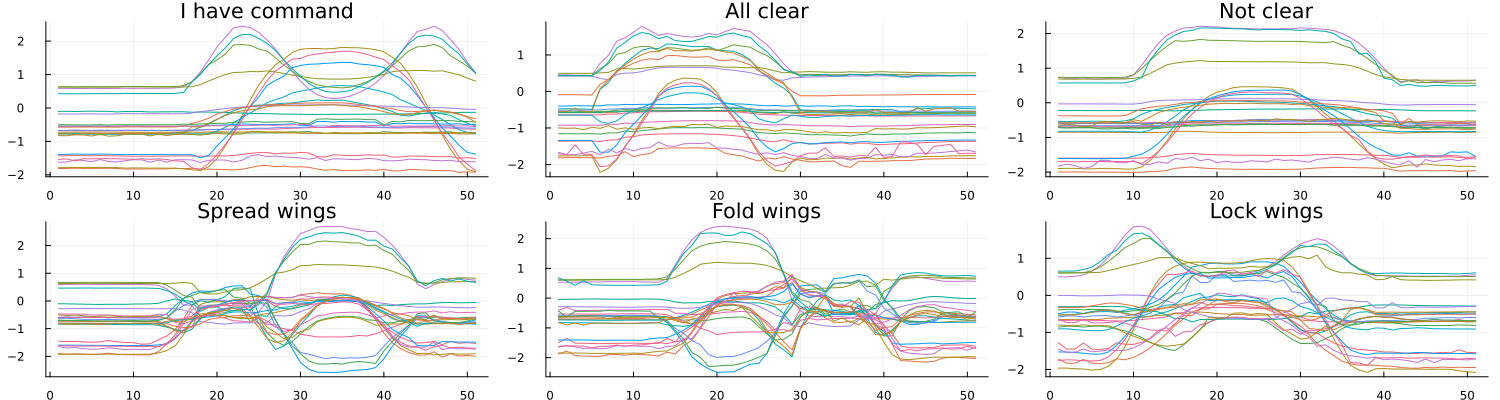

In [9]:
 # let us summarize one instance for each class
plot(map(i -> 
    plot(collect(X[i,:]), 
        labels=nothing,
        title=y[i]), 
        1:30:180
    )..., 
    layout = (2, 3), 
    size = (1500,400)
)

In [10]:
# length of X[hand tip l] of the first instance 
length(X[1,1])

51

In [11]:
# each instance can be shaped as a Kripke Frame, whose worlds encode all the intervals 
# in the range [1, 51] (including the degenerate, punctual cases such as [1, 1])
fr = SoleLogics.frame(X, 1)

FullDimensionalFrame{1, SoleLogics.Interval{Int64}}((51,))

In [12]:
allworlds(fr) |> collect

1326-element Vector{SoleLogics.Interval{Int64}}:
 SoleLogics.Interval{Int64}(1, 2)
 SoleLogics.Interval{Int64}(1, 3)
 SoleLogics.Interval{Int64}(2, 3)
 SoleLogics.Interval{Int64}(1, 4)
 SoleLogics.Interval{Int64}(2, 4)
 SoleLogics.Interval{Int64}(3, 4)
 SoleLogics.Interval{Int64}(1, 5)
 SoleLogics.Interval{Int64}(2, 5)
 SoleLogics.Interval{Int64}(3, 5)
 SoleLogics.Interval{Int64}(4, 5)
 ⋮
 SoleLogics.Interval{Int64}(43, 52)
 SoleLogics.Interval{Int64}(44, 52)
 SoleLogics.Interval{Int64}(45, 52)
 SoleLogics.Interval{Int64}(46, 52)
 SoleLogics.Interval{Int64}(47, 52)
 SoleLogics.Interval{Int64}(48, 52)
 SoleLogics.Interval{Int64}(49, 52)
 SoleLogics.Interval{Int64}(50, 52)
 SoleLogics.Interval{Int64}(51, 52)

In [13]:
using SoleLogics: Interval

# enumerate the intervals that are "Later" than [1,10]
collect(accessibles(fr, Interval(1,10), IA_L))

861-element Vector{Interval{Int64}}:
 Interval{Int64}(11, 12)
 Interval{Int64}(11, 13)
 Interval{Int64}(12, 13)
 Interval{Int64}(11, 14)
 Interval{Int64}(12, 14)
 Interval{Int64}(13, 14)
 Interval{Int64}(11, 15)
 Interval{Int64}(12, 15)
 Interval{Int64}(13, 15)
 Interval{Int64}(14, 15)
 ⋮
 Interval{Int64}(43, 52)
 Interval{Int64}(44, 52)
 Interval{Int64}(45, 52)
 Interval{Int64}(46, 52)
 Interval{Int64}(47, 52)
 Interval{Int64}(48, 52)
 Interval{Int64}(49, 52)
 Interval{Int64}(50, 52)
 Interval{Int64}(51, 52)

In [14]:
# we compute the value of a certain feature on each world where we can
feature = SoleData.VariableMax(4)

VariableMax{Int64}: max[V4]

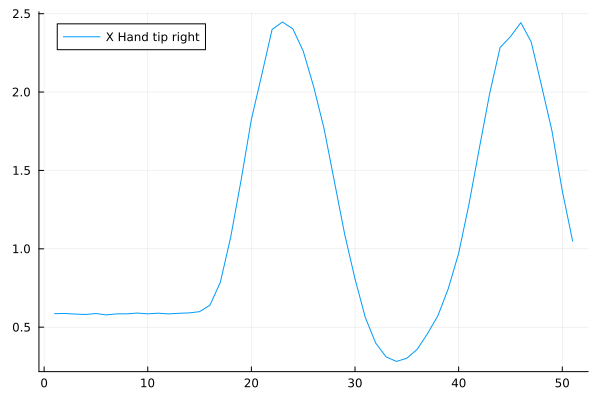

In [15]:
plot(X[1, 4], labels="X Hand tip right")

In [16]:
SoleData.featvalue(feature, X, 1, Interval(10, 30))

2.446918

In [17]:
# when we are interested in windowing the data, it is easy to transform a dataset into a 
# Kripke Model
Xk = scalarlogiset(X)

SupportedLogiset with 1 support (342.94 MBs)
├ worldtype:                   Interval{Int64}
├ featvaltype:                 Float64
├ featuretype:                 SoleData.AbstractUnivariateFeature
├ frametype:                   FullDimensionalFrame{1, Interval{Int64}}
├ # instances:                 360
├ usesfullmemo:                true
├[BASE] UniformFullDimensionalLogiset of channel size (51,) (342.91 MBs)
│ ├ size × eltype:              (51, 51, 360, 48) × Float64
│ └ features:                   48 -> SoleData.AbstractUnivariateFeature[max[V1], min[V1], max[V2], min[V2], ..., min[V22], max[V23], min[V23], max[V24], min[V24]]
└[SUPPORT 1] FullMemoset (0 memoized values, 31.03 KBs))


In [18]:
# we can check custom conditions over the logiset we just created
p = Atom(ScalarCondition(feature, <, 1.0))
check(p, Xk, 1, Interval(10, 30))

false

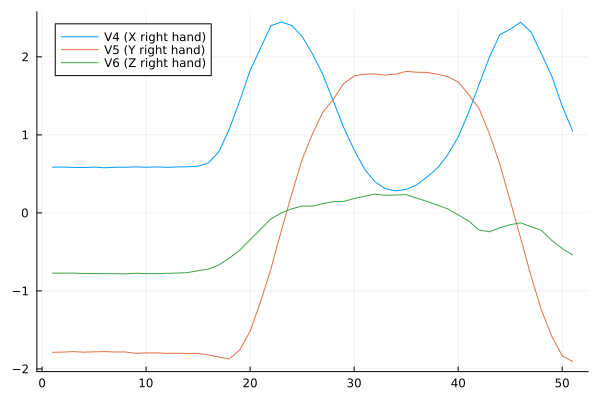

In [19]:
plot(collect(X[1, 4:6]), labels=["V4 (X right hand)" "V5 (Y right hand)" "V6 (Z right hand)"])

In [20]:
p = Atom(ScalarCondition(VariableMin(4), >, 1.0))
q = Atom(ScalarCondition(VariableMax(5), <=, 3.0))
r = Atom(ScalarCondition(VariableMax(6), <=, 0.0))

phi = ¬p ∨ (q ∧ r)
println(syntaxstring(phi))

check(phi, SoleLogics.LogicalInstance(Xk, 1), Interval(10, 30))

¬min[V4] > 1.0 ∨ (max[V5] ≤ 3.0 ∧ max[V6] ≤ 0.0)


true

Let us try to check some modal formulae.

In [21]:
boxlater = box(SoleLogics.IA_A)

BoxRelationalConnective{SoleLogics._IA_A}: [A]

In [22]:
later_always_phi = boxlater(phi)

SyntaxBranch: [A](¬min[V4] > 1.0 ∨ (max[V5] ≤ 3.0 ∧ max[V6] ≤ 0.0))

In [23]:
check(later_always_phi, SoleLogics.LogicalInstance(Xk, 1), Interval(10, 30))

true

In [24]:
SoleLogics.getinstance(Xk, 1)

SoleLogics.LogicalInstance{SupportedLogiset{Interval{Int64}, Float64, SoleData.AbstractUnivariateFeature, FullDimensionalFrame{1, Interval{Int64}}, SoleData.DimensionalDatasets.UniformFullDimensionalLogiset{Float64, Interval{Int64}, 1, Array{Float64, 4}, SoleData.AbstractUnivariateFeature, FullDimensionalFrame{1, Interval{Int64}}}, 1, Tuple{SoleData.FullMemoset{Interval{Int64}, Vector{ThreadSafeDicts.ThreadSafeDict{SyntaxTree, Vector{Interval{Int64}}}}}}}}(SupportedLogiset with 1 support (343.06 MBs)
├ worldtype:                   Interval{Int64}
├ featvaltype:                 Float64
├ featuretype:                 SoleData.AbstractUnivariateFeature
├ frametype:                   FullDimensionalFrame{1, Interval{Int64}}
├ # instances:                 360
├ usesfullmemo:                true
├[BASE] UniformFullDimensionalLogiset of channel size (51,) (342.91 MBs)
│ ├ size × eltype:              (51, 51, 360, 48) × Float64
│ └ features:                   48 -> SoleData.AbstractUnivariateF

In [25]:
# let us try with an even more complex scenario
check_mask = zeros(Int64, 51)
for i in 1:X_ndatapoints
    check_mask[i] = check(phi, SoleLogics.LogicalInstance(Xk, i), Interval(1,30))
end

println(check_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Modal Decision Trees

In [26]:
using SoleBase
using ModalDecisionTrees

In [27]:
# the experiment we are just going to execute could be too 
# heavy for standard commodity hardware;
# we can reduce data dimensionality via a moving window
X_small = broadcast(x -> movingwindow(mean, x; nwindows = 10, relative_overlap = 0.2), X)

X_small_ninstances, X_small_nattributes = size(X_small)
X_small_ndatapoints = length(X_small[1,1])

println("The number of datapoints changed from $(X_ndatapoints) to $(X_small_ndatapoints)")

The number of datapoints changed from 51 to 10


In [28]:
features = [maximum, minimum]
Xk_small = scalarlogiset(X_small, features)

SupportedLogiset with 1 support (13.22 MBs)
├ worldtype:                   Interval{Int64}
├ featvaltype:                 Float64
├ featuretype:                 SoleData.AbstractUnivariateFeature
├ frametype:                   FullDimensionalFrame{1, Interval{Int64}}
├ # instances:                 360
├ usesfullmemo:                true
├[BASE] UniformFullDimensionalLogiset of channel size (10,) (13.19 MBs)
│ ├ size × eltype:              (10, 10, 360, 48) × Float64
│ └ features:                   48 -> SoleData.AbstractUnivariateFeature[max[X[Hand tip l]], min[X[Hand tip l]], max[Y[Hand tip l]], min[Y[Hand tip l]], ..., min[X[Thumb r]], max[Y[Thumb r]], min[Y[Thumb r]], max[Z[Thumb r]], min[Z[Thumb r]]]
└[SUPPORT 1] FullMemoset (0 memoized values, 31.03 KBs))


In [29]:
model = ModalDecisionTree(; relations = :IA, features = [minimum, maximum])

ModalDecisionTree(
  max_depth = nothing, 
  min_samples_leaf = 4, 
  min_purity_increase = 0.002, 
  max_purity_at_leaf = Inf, 
  max_modal_depth = nothing, 
  relations = :IA, 
  features = nothing, 
  conditions = Function[minimum, maximum], 
  featvaltype = Float64, 
  initconditions = nothing, 
  downsize = SoleData.var"#downsize#541"(), 
  force_i_variables = true, 
  fixcallablenans = false, 
  print_progress = false, 
  rng = TaskLocalRNG(), 
  display_depth = nothing, 
  min_samples_split = nothing, 
  n_subfeatures = identity, 
  post_prune = false, 
  merge_purity_threshold = nothing, 
  feature_importance = :split)

In [30]:
(X_small_train, X_small_test), (y_small_train, y_small_test) = partition(
    (X_small, y), 0.7, rng=121, shuffle=true, multi=true);

In [31]:
# bind the modal decision tree to the logiset;
# then train it and compute the accuracy

mach = machine(model, X_small_train, y_small_train)
@time fit!(mach);

y_small_predict_probabilities = MLJ.predict(mach, X_small_test)
y_small_predict = mode.(y_small_predict_probabilities)

MLJ.accuracy(y_small_predict, y_small_test)

┌ Info: Precomputing logiset...
└ @ SoleData /home/mauro/.julia/packages/SoleData/N5aE8/src/utils/autologiset-tools.jl:259
┌ Info: Training machine(ModalDecisionTree(max_depth = nothing, …), …).
└ @ MLJBase /home/mauro/.julia/packages/MLJBase/GY2fM/src/machines.jl:499


 46.429091 seconds (298.75 M allocations: 10.267 GiB, 4.57% gc time, 121.37% compilation time: <1% of which was recompilation)


0.9074074074074074

In [32]:
# show the restricted modal decision tree learned
printmodel(report(mach).rawmodel_full; hidemodality = true)

{1} RestrictedDecision(⟨G⟩min[V1] ≥ 0.004682285714285718)    Spread wings : 45/252 (conf = 0.1786)
✔ {1} RestrictedDecision(⟨A⟩min[V1] < -1.3483151428571427)   Spread wings : 45/128 (conf = 0.3516)
│✔ {1} RestrictedDecision(⟨=⟩min[V2] ≥ -0.044073125)         Spread wings : 45/46 (conf = 0.9783)
││✔ Spread wings : 42/42 (conf = 1.0000)
││✘ Spread wings : 3/4 (conf = 0.7500)
│✘ {1} RestrictedDecision(⟨L̅⟩min[V8] ≥ -0.09982599999999998) Lock wings : 42/82 (conf = 0.5122)
│ ✔ Fold wings : 40/40 (conf = 1.0000)
│ ✘ Lock wings : 42/42 (conf = 1.0000)
✘ {1} RestrictedDecision(⟨G⟩min[V5] ≥ 0.7817771428571428)    All clear : 43/124 (conf = 0.3468)
 ✔ {1} RestrictedDecision(⟨A̅⟩max[V22] < 1.792701125)         I have command : 38/43 (conf = 0.8837)
 │✔ I have command : 38/38 (conf = 1.0000)
 │✘ All clear : 3/5 (conf = 0.6000)
 ✘ {1} RestrictedDecision(⟨G⟩min[V11] ≥ 0.188145)            Not clear : 41/81 (conf = 0.5062)
  ✔ {1} RestrictedDecision(⟨=⟩min[V5] ≥ 0.6772125714285714)  Not clear : 25/28

In [33]:
# show its *pure* version
printmodel(report(mach).solemodel_full; show_metrics = true, hidemodality = true)

▣ (⟨G⟩(min[V1] ≥ 0.004682285714285718))
├✔ (⟨G⟩((min[V1] ≥ 0.004682285714285718) ∧ ⟨A⟩(min[V1] < -1.3483151428571427)))
│ ├✔ (⟨G⟩((min[V1] ≥ 0.004682285714285718) ∧ ⟨A⟩((min[V1] < -1.3483151428571427) ∧ (min[V2] ≥ -0.044073125))))
│ │ ├✔ Spread wings : (ninstances = 42, ncovered = 42, confidence = 1.0, lift = 1.0)
│ │ └✘ Spread wings : (ninstances = 4, ncovered = 4, confidence = 0.75, lift = 1.0)
│ └✘ (⟨G⟩((min[V1] ≥ 0.004682285714285718) ∧ ⟨L̅⟩(min[V8] ≥ -0.09982599999999998)))
│   ├✔ Fold wings : (ninstances = 40, ncovered = 40, confidence = 1.0, lift = 1.0)
│   └✘ Lock wings : (ninstances = 42, ncovered = 42, confidence = 1.0, lift = 1.0)
└✘ (⟨G⟩(min[V5] ≥ 0.7817771428571428))
  ├✔ (⟨G⟩((min[V5] ≥ 0.7817771428571428) ∧ ⟨A̅⟩(max[V22] < 1.792701125)))
  │ ├✔ I have command : (ninstances = 38, ncovered = 38, confidence = 1.0, lift = 1.0)
  │ └✘ All clear : (ninstances = 5, ncovered = 5, confidence = 0.6, lift = 1.0)
  └✘ (⟨G⟩(min[V11] ≥ 0.188145))
    ├✔ (⟨G⟩((min[V11] ≥ 0.188145) ∧ (m

In [34]:
simplified_restricted_tree = ModalDecisionTrees.prune(
    report(mach).rawmodel_full; simplify = true)

puretree = ModalDecisionTrees.translate(simplified_restricted_tree)
printmodel(
    puretree; 
    threshold_digits = 2, 
    use_feature_abbreviations = true, 
    parenthesize_atoms = false, 
    variable_names_map = [names(X)], 
    hidemodality = true
)

println("# Leaves: ", SoleModels.nsubmodels(puretree))
println("# Classes: ", length(unique(y)))

▣ (⟨G⟩X[Hand tip l] ⪰ 0.0)
├✔ (⟨G⟩(X[Hand tip l] ⪰ 0.0 ∧ ⟨A⟩X[Hand tip l] ↓ -1.35))
│ ├✔ Spread wings
│ └✘ (⟨G⟩(X[Hand tip l] ⪰ 0.0 ∧ ⟨L̅⟩Y[Elbow l] ⪰ -0.1))
│   ├✔ Fold wings
│   └✘ Lock wings
└✘ (⟨G⟩Y[Hand tip r] ⪰ 0.78)
  ├✔ (⟨G⟩(Y[Hand tip r] ⪰ 0.78 ∧ ⟨A̅⟩X[Thumb r] ≺ 1.79))
  │ ├✔ I have command
  │ └✘ All clear
  └✘ (⟨G⟩Y[Elbow r] ⪰ 0.19)
    ├✔ (⟨G⟩(Y[Elbow r] ⪰ 0.19 ∧ Y[Hand tip r] ⪰ 0.68))
    │ ├✔ All clear
    │ └✘ Not clear
    └✘ (⟨G⟩Y[Hand tip r] ⪰ 0.32)
      ├✔ All clear
      └✘ (⟨G⟩Y[Elbow r] ⪰ 0.0)
        ├✔ Not clear
        └✘ (⟨G⟩Y[Hand tip r] ⪰ 0.07)
          ├✔ All clear
          └✘ Not clear
# Leaves: 20
# Classes: 6


In [35]:
# print the leaf rules and their training performances
ruleset = listrules(puretree)
printmodel.(
    ruleset; 
    show_metrics = true, 
    threshold_digits = 2, 
    use_feature_abbreviations = true, 
    parenthesize_atoms = false, 
    hidemodality = true
);

▣ (⟨G⟩(V1 ⪰ 0.0 ∧ ⟨A⟩V1 ↓ -1.35))  ↣  Spread wings : (ninstances = 252, ncovered = 46, coverage = 0.18, confidence = 0.98, lift = 5.48, natoms = 2)
▣ ⟨G⟩(V1 ⪰ 0.0 ∧ ⟨L̅⟩V8 ⪰ -0.1) ∧ [G](V1 ⪰ 0.0 → [A]V1 ⪰ -1.35)  ↣  Fold wings : (ninstances = 252, ncovered = 40, coverage = 0.16, confidence = 1.0, lift = 6.15, natoms = 4)
▣ ⟨G⟩V1 ⪰ 0.0 ∧ [G](V1 ⪰ 0.0 → [A]V1 ⪰ -1.35) ∧ [G](V1 ⪰ 0.0 → [L̅]V8 ↓ -0.1)  ↣  Lock wings : (ninstances = 252, ncovered = 42, coverage = 0.17, confidence = 1.0, lift = 6.0, natoms = 5)
▣ ⟨G⟩(V5 ⪰ 0.78 ∧ ⟨A̅⟩V22 ≺ 1.79) ∧ [G]V1 ↓ 0.0  ↣  I have command : (ninstances = 252, ncovered = 38, coverage = 0.15, confidence = 1.0, lift = 6.63, natoms = 3)
▣ ⟨G⟩V5 ⪰ 0.78 ∧ [G]V1 ↓ 0.0 ∧ [G](V5 ⪰ 0.78 → [A̅]V22 ⤒ 1.79)  ↣  All clear : (ninstances = 252, ncovered = 5, coverage = 0.02, confidence = 0.6, lift = 3.52, natoms = 4)
▣ ⟨G⟩(V11 ⪰ 0.19 ∧ V5 ⪰ 0.68) ∧ [G]V1 ↓ 0.0 ∧ [G]V5 ↓ 0.78  ↣  All clear : (ninstances = 252, ncovered = 4, coverage = 0.02, confidence = 0.75, lift = 4.4

In [36]:
println("IF\n\t", 
    SoleLogics.experimentals.formula2natlang(
        antecedent(ruleset[4]);
        threshold_digits = 2,
        variable_names_map = [names(X)]
    )
)

println("THEN\n\t", consequent(ruleset[4]))

IF
	(∃ interval where ((min[Y[Hand tip r]] ≥ 0.78) and (∃ preceding interval where (max[X[Thumb r]] < 1.79)))) and (∀ intervals (min[X[Hand tip l]] < 0.0))
THEN
	▣ I have command



### Modal Association Rules

Now, we follow an *unsupervised* approach, ignoring the class label.

The hypothesis here, is that a logical formula is *interesting*, if it happens 
to be frequently satisfied across all the instances of a dataset $\mathcal{I}$.

Given an alphabet $\mathcal{P}$ of propositional literals, the formula we are dealing with
are literal conjunctions called *itemsets*.

An itemset that is also frequent is called *frequent itemset*.

More formally, given a dataset $\mathcal{I}$, a propositional alphabet $\mathcal{P}$
and a minimum threshold $s$, a frequent pattern $\mathsf{P} \subseteq \mathcal{P}$ is such that:

$$\text{support}(\mathcal{I}, \mathsf{P}) = \frac{| \{I \in \mathcal{I} \mid I \models \mathsf{P} \} |}{|\mathcal{I}|} \geq s$$

The ratio above is called *support*.

In [37]:
using ModalAssociationRules

In [38]:
# these are just three toy atoms
p = Atom(ScalarCondition(VariableMax(4), >=, 2)) |> Item
q = Atom(ScalarCondition(VariableMin(5), <=, 1.5)) |> Item
r = Atom(ScalarCondition(VariableMax(6), >=, 0.0)) |> Item

max[V6] ≥ 0.0

In [39]:
# an Itemset encodes a conjunction of SoleLogics.Formula, but has two advantages:

# 1) performance considerations that really suit the field of association rule mining 
# https://towardsdev.com/set-vs-vector-lookup-in-julia-a-closer-look-9d106d01ccae

# 2) they prevent type piracy!

pq = Itemset([p, q])
pr = Itemset([p, r])
qr = Itemset([q, r])
pqr = Itemset([p, q, r])

3-element Vector{Item}:
 max[V4] ≥ 2
 min[V5] ≤ 1.5
 max[V6] ≥ 0.0

In [40]:
# an Itemset can wrap any SoleLogics.Formula type;
# it prevent 
formula(pq)

LeftmostConjunctiveForm with 2 Atom grandchildren:
	max[V4] ≥ 2
	min[V5] ≤ 1.5


##### Exercise:
Define your own `mysupport` function.

Its argument must be of type `SoleLogics.Formula`, `SoleData.AbstractLogiset` and `SoleLogics.AbstractWorld`.

We only want to consider the instances that were originally associated with the `I have command` class.

We want to treat the Kripke model as a degenerate propositional logiset.

Then compute the support of the following itemsets: `p`, `q`, `r`, `p ∧ q`, `p ∧ r`, `r ∧ q`, `p ∧ q ∧ r`. 

The support must be rounded to the second decimal digit.

Solution (Base64):
ZnVuY3Rpb24gbXlzdXBwb3J0KHBoaTo6RiwgWGs6OkwsIHdvcmxkOjpXKSB3aGVyZSB7CiAgICBGPDpTb2xlTG9naWNzLkZvcm11bGEsIAogICAgTDw6U29sZURhdGEuQWJzdHJhY3RMb2dpc2V0LCAKICAgIFc8OlNvbGVMb2dpY3MuQWJzdHJhY3RXb3JsZAp9CiAgICAKICAgIF9uaW5zdGFuY2VzID0gbmluc3RhbmNlcyhYaykKCiAgICBjaGVja19tYXNrID0gemVyb3MoSW50OCwgX25pbnN0YW5jZXMpCgogICAgQGluYm91bmRzIEBzaW1kIGZvciBpIGluIDE6X25pbnN0YW5jZXMgCiAgICAgICAgY2hlY2tfbWFza1tpXSA9IGNoZWNrKHBoaSwgWGssIGksIHdvcmxkKQogICAgZW5kCgogICAgcmV0dXJuIHJvdW5kKG1lYW4oY2hlY2tfbWFzayk7IGRpZ2l0cyA9IDIpCmVuZA==

In [41]:
# Write your definition here

In [42]:
try
    for phi in [p, q, r, pq, pr, qr, pqr]
        println(
            mysupport(formula(phi), SoleData.slicedataset(Xk, 1:30), Interval(1, X_ndatapoints)))
    end
catch e
    if e isa UndefVarError
        println("You need to implement mysupport.")
    end
end 

You need to implement mysupport.


Let us consider an alphabet of propositional literals $\mathcal{P}$, and let us suppose that 
$\mathsf{P} \subseteq \mathcal{P}$ is a frequent pattern we found.

We can partition $\mathsf{P}$ in two smaller frequent patterns, $\mathsf{Q}, \mathsf{R}$, such that $\mathsf{Q} \cap \mathsf{R} = \emptyset$.

We denote with $\mathsf{Q} \Rightarrow \mathsf{R}$ the fact that an *interesting* statistical relation occurs between the antecedent and the consequent: if this is the case, then we have an *association rule*.

Similarly to the case of frequent patterns, the interestingness must be established with specific measures, which are called *meaningfulness measures* in the jargon.

In [43]:
# beware of the difference between an Item (such as p) and an Itemset;
# we need to cast p to Itemset, even if it is a trivial 1-length Itemset.
println(typeof(p))
ARule(Itemset(p), qr)

Item{Atom{ScalarCondition{Int64, VariableMax{Int64}, ScalarMetaCondition{VariableMax{Int64}, typeof(>=)}}}}


max[V4] ≥ 2 => (min[V5] ≤ 1.5) ∧ (max[V6] ≥ 0.0)

In [44]:
try
    ARule(pq, qr)
catch e 
    if e isa ArgumentError
        println("Beware: pq ∩ qr is not empty.")
    end
end

Beware: pq ∩ qr is not empty.


In [45]:
rule = ARule(Itemset(p), qr)

max[V4] ≥ 2 => (min[V5] ≤ 1.5) ∧ (max[V6] ≥ 0.0)

In [46]:
ModalAssociationRules.antecedent(rule)

1-element Vector{Item{Atom{ScalarCondition{Int64, VariableMax{Int64}, ScalarMetaCondition{VariableMax{Int64}, typeof(>=)}}}}}:
 max[V4] ≥ 2

In [47]:
ModalAssociationRules.consequent(rule)

2-element Vector{Item}:
 min[V5] ≤ 1.5
 max[V6] ≥ 0.0

##### Quiz

Try to explain the ratio below, which is commonly called *confidence*.

$$\text{confidence}(\mathcal{I}, \mathsf{P} \Rightarrow \mathsf{Q}) = \frac{\text{support}(\mathcal{I}, \mathsf{P} \cap \mathsf{Q})}{\text{support}(\mathcal{I}, \mathsf{P})}$$

In [48]:
# get the generator Itemset back
Itemset(rule)

3-element Vector{Item}:
 max[V4] ≥ 2
 min[V5] ≤ 1.5
 max[V6] ≥ 0.0

##### Exercise

Implement your own `myconfidence` function.

Solution (Base 64):
ZnVuY3Rpb24gbXljb25maWRlbmNlKHJ1bGU6OkFSdWxlLCBYazo6TCwgd29ybGQ6OlcpIHdoZXJlIHsKICAgIEw8OlNvbGVEYXRhLkFic3RyYWN0TG9naXNldCwgCiAgICBXPDpTb2xlTG9naWNzLkFic3RyYWN0V29ybGQKfQogICAgZnVsbF9mb3JtdWxhID0gZm9ybXVsYShJdGVtc2V0KHJ1bGUpKQogICAgYW50ZWNlZGVudF9mb3JtdWxhID0gZm9ybXVsYShNb2RhbEFzc29jaWF0aW9uUnVsZXMuYW50ZWNlZGVudChydWxlKSkKCiAgICByZXR1cm4gbXlzdXBwb3J0KGZ1bGxfZm9ybXVsYSwgWGssIHdvcmxkKSAvIG15c3VwcG9ydChhbnRlY2VkZW50X2Zvcm11bGEsIFhrLCB3b3JsZCkgCmVuZA==

In [49]:
# Insert your solution here

In [52]:
try
    for phi in [p, q, r, pq, pr, qr, pqr]
        println(
            myconfidence(rule, SoleData.slicedataset(Xk, 1:30), Interval(1, X_ndatapoints)))
    end
catch e
    if e isa UndefVarError
        println("You need to implement myconfidence.")
    end
end 

You need to implement myconfidence.


##### Enhancing Modal Association Rules with Modalities

When dealing with Kripke models, a natural dichotomy pops up!

Let us consider an alphabet of modal literals $\Lambda_\mathcal{P}$, obtained by enriching a standard,
propositional alphabet $\mathcal{P}$ with modal operators.

Let us also consider a modal dataset $\mathcal{I}$ and an instance $I = (W,R,v) \in \mathcal{I}$ in it, 
as well as a pattern $\mathsf{P}$.

We can assess the interestingness of $\mathsf{P}$ within an instance by computing its *local support*, and comparing it 
with respect to a *minimum local support threshold* $s_l$.

$$\text{lsupport}(I, \mathsf{P}) = \frac{ |\{w \in W \mid I, w \models \mathsf{P} \}| }{|\mathcal{W}|}$$

The other part of the dichotomy, that is, the notion of *global* support, is left as an exercise (see the Quiz below).

##### Quiz
How would you aggregate many local support computations, to compute a *global* support?

##### Mining Association Rules from Time Series Items

We want to probe our instances with considerations on the shape of the signal in a certain interval, for a given feature.

We also want to increase the expressiveness of the result association rules with the help of `HS` logic.

In [133]:
function _normalize(x::Vector{<:Real})
    eps = 1e-10
    return (x .- mean(x)) ./ (std(x) + eps)
end

# euclidean distance between normalized(x) and normalized(y)
function zeuclidean(x::Vector{<:Real}, y::Vector{<:Real})
    if length(x) != length(y)
        # TODO - instead of returning a big number, throw an error and catch it while mining
        return maxintfloat()
    end

    # normalize x and y
    meanx = mean(x)
    meany = mean(y)

    # avoid division by zero
    eps = 1e-10

    x_z = _normalize(x)
    y_z = _normalize(y)

    # z-normalized euclidean distance formula
    return sqrt(sum((x_z .- y_z).^2))
end

expdistance = (x, y) -> zeuclidean(x, y) |> first;

In [128]:
# consider only right hand and right elbow
varids = vcat(collect(4:6), collect(10:12));

In [129]:
mar_res_path = joinpath(@__DIR__, "..", "res", "natops-for-mar")

"/home/mauro/.julia/dev/logic-and-machine-learning/notebooks/../res/natops-for-mar"

In [130]:
using Serialization

function load_motifs(filepath, save_filename_prefix)
    ids = [id for id in deserialize(joinpath(filepath, "$(save_filename_prefix)-ids"))];
    motifs = [m for m in deserialize(joinpath(filepath, "$(save_filename_prefix)-motifs"))];
    featurenames = [f for f in deserialize(joinpath(filepath, "$(save_filename_prefix)-featurenames"))];
    return ids, motifs, featurenames
end


ids, motifs, featurenames = load_motifs(mar_res_path, "NATOPS-IHCC");

In [131]:
variables = [
    SoleData.VariableDistance(id, m, distance=zeuclidean, featurename=name)
    for (id, m, name) in zip(ids, motifs, featurenames)
]

syntaxstring.(variables)[1:3]

3-element Vector{String}:
 "left[V4]"
 "right[V4]"
 "inv_left[V4]"

In [132]:
# we only consider the instances related to the "I have command" class;
# we are not cheating: in this unsupervised setting, we just want to describe them
IHCC = reduce(vcat, [X[1:30, :], X[(180+1):(180+30), :]]);
IHCCk = ModalAssociationRules.scalarlogiset(IHCC, variables)

CompositeException: TaskFailedException

    nested task error: MethodError: no method matching _normalize(::Float64)
    The function `_normalize` exists, but no method is defined for this combination of argument types.
    
    Closest candidates are:
      _normalize(!Matched::Vector{<:Real}; eps)
       @ Main ~/.julia/dev/logic-and-machine-learning/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y116sZmlsZQ==.jl:2
    
    Stacktrace:
      [1] zeuclidean(x::Vector{Float64}, y::Vector{Float64})
        @ Main ~/.julia/dev/logic-and-machine-learning/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y116sZmlsZQ==.jl:9
      [2] (::SoleData.DimensionalDatasets.var"#37#38"{VariableDistance{Int64, Vector{Float64}}, Vector{Float64}})(reference::Vector{Float64})
        @ SoleData.DimensionalDatasets ~/.julia/packages/SoleData/N5aE8/src/dimensional-structures/computefeature.jl:65
      [3] iterate
        @ ./generator.jl:48 [inlined]
      [4] _collect(c::Vector{Vector{Float64}}, itr::Base.Generator{Vector{Vector{Float64}}, SoleData.DimensionalDatasets.var"#37#38"{VariableDistance{Int64, Vector{Float64}}, Vector{Float64}}}, ::Base.EltypeUnknown, isz::Base.HasShape{1})
        @ Base ./array.jl:811
      [5] collect_similar(cont::Vector{Vector{Float64}}, itr::Base.Generator{Vector{Vector{Float64}}, SoleData.DimensionalDatasets.var"#37#38"{VariableDistance{Int64, Vector{Float64}}, Vector{Float64}}})
        @ Base ./array.jl:720
      [6] map(f::Function, A::Vector{Vector{Float64}})
        @ Base ./abstractarray.jl:3371
      [7] computeunivariatefeature(f::VariableDistance{Int64, Vector{Float64}}, varchannel::Vector{Float64}; aggregator::Function)
        @ SoleData.DimensionalDatasets ~/.julia/packages/SoleData/N5aE8/src/dimensional-structures/computefeature.jl:65
      [8] computeunivariatefeature
        @ ~/.julia/packages/SoleData/N5aE8/src/dimensional-structures/computefeature.jl:55 [inlined]
      [9] readfeature(dataset::DataFrame, featchannel::Vector{Float64}, w::Interval{Int64}, f::VariableDistance{Int64, Vector{Float64}})
        @ SoleData.DimensionalDatasets ~/.julia/packages/SoleData/N5aE8/src/dimensional-structures/logiseeds/abstractdataframe.jl:127
     [10] featvalue(feature::VariableDistance{Int64, Vector{Float64}}, dataset::DataFrame, i_instance::Int64, w::Interval{Int64})
        @ SoleData.DimensionalDatasets ~/.julia/packages/SoleData/N5aE8/src/dimensional-structures/logiseeds/abstractdataframe.jl:144
     [11] macro expansion
        @ ~/.julia/packages/SoleData/N5aE8/src/scalar/scalarlogiset.jl:302 [inlined]
     [12] (::SoleData.var"#527#threadsfor_fun#264"{SoleData.var"#527#threadsfor_fun#244#265"{Bool, DataFrame, Base.Iterators.Zip{Tuple{Vector{Int64}, Vector{VariableDistance{Int64, Vector{Float64}}}}}, Vector{FullDimensionalFrame{1, Interval{Int64}}}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ SoleData ./threadingconstructs.jl:253
     [13] #527#threadsfor_fun
        @ ./threadingconstructs.jl:220 [inlined]
     [14] (::Base.Threads.var"#1#2"{SoleData.var"#527#threadsfor_fun#264"{SoleData.var"#527#threadsfor_fun#244#265"{Bool, DataFrame, Base.Iterators.Zip{Tuple{Vector{Int64}, Vector{VariableDistance{Int64, Vector{Float64}}}}}, Vector{FullDimensionalFrame{1, Interval{Int64}}}, UnitRange{Int64}}}, Int64})()
        @ Base.Threads ./threadingconstructs.jl:154

...and 11 more exceptions.


In [97]:
propositionalatoms = [
    Atom(ScalarCondition(v, <=, 1.0))
    for v in variables
]

syntaxstring.(propositionalatoms)[1:3]

3-element Vector{String}:
 "left[V4] ≤ 1.0"
 "right[V4] ≤ 1.0"
 "inv_left[V4] ≤ 1.0"

In [98]:
atoms = Vector{Item}(
    reduce(vcat, [
        propositionalatoms,
        diamond(IA_A).(propositionalatoms),
        diamond(IA_B).(propositionalatoms),
        diamond(IA_E).(propositionalatoms),
        diamond(IA_D).(propositionalatoms),
        diamond(IA_O).(propositionalatoms),
    ])
)

syntaxstring.(atoms)[1:3]

3-element Vector{String}:
 "left[V4] ≤ 1.0"
 "right[V4] ≤ 1.0"
 "inv_left[V4] ≤ 1.0"

In [100]:
_items = Vector{Item}(atoms);

In [102]:
miner = Miner(
    IHCCk,
    apriori,
    _items,
    [(gsupport, 0.1, 0.1)],
    [(gconfidence, 0.5, 0.5)];
    _worldfilter=SoleLogics.FunctionalWorldFilter(
        x -> (length(x) == 10) || (length(x) == 20), Interval{Int}
    )
)

MethodError: MethodError: no method matching Miner(::SupportedLogiset{Interval{Int64}, Float64, SoleData.AbstractUnivariateFeature, FullDimensionalFrame{1, Interval{Int64}}, UniformFullDimensionalLogiset{Float64, Interval{Int64}, 1, Array{Float64, 4}, SoleData.AbstractUnivariateFeature, FullDimensionalFrame{1, Interval{Int64}}}, 1, Tuple{SoleData.FullMemoset{Interval{Int64}, Vector{ThreadSafeDicts.ThreadSafeDict{SyntaxTree, Vector{Interval{Int64}}}}}}}, ::typeof(apriori), ::Vector{Item}, ::Vector{Tuple{typeof(gsupport), Float64, Float64}}, ::Vector{Tuple{typeof(gconfidence), Float64, Float64}}; _worldfilter::FunctionalWorldFilter{Interval{Int64}, var"#70#71"})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  Miner(::D, ::Function, ::Vector{I}, ::Vector{<:Tuple{Function, Float64, Float64}}, ::Vector{<:Tuple{Function, Float64, Float64}}; worldfilter, itemset_policies, arule_policies, info) where {D<:AbstractDataset, I<:Item} got unsupported keyword argument "_worldfilter"
   @ ModalAssociationRules ~/.julia/packages/ModalAssociationRules/SPE2Z/src/utils/miner.jl:142
  Miner(::D, ::Function, ::Vector{I}, ::Vector{<:Tuple{Function, Float64, Float64}}; ...) where {D<:AbstractDataset, I<:Item}
   @ ModalAssociationRules ~/.julia/packages/ModalAssociationRules/SPE2Z/src/utils/miner.jl:142
  Miner(::D, ::Function, ::Vector{I}; ...) where {D<:AbstractDataset, I<:Item}
   @ ModalAssociationRules ~/.julia/packages/ModalAssociationRules/SPE2Z/src/utils/miner.jl:142


## Learning with Many-Valued Logic

### Many-Expert Decision Trees

`ManyExpertDecisionTrees.jl` is still in development and has not been released
yet!

In [ ]:
using ManyExpertDecisionTrees
using ManyExpertDecisionTrees: build_tree, prune_tree, FL

In [ ]:
using SoleLogics.ManyValuedLogics

allexperts = (GodelLogic, LukasiewiczLogic, ProductLogic)

In [ ]:
using Combinatorics

# Compute all possible expert compbinations (with replacement)
expertcomb = begin
    c = Vector{Vector{FuzzyLogic}}()
    for i in 1:length(allexperts)
        append!(c, collect(Combinatorics.with_replacement_combinations(allexperts, i)))
    end
    c
end

In [ ]:
using RDatasets # used to load the iris dataset


data = RDatasets.dataset("datasets", "iris");

In [ ]:
# This is useful to read results later 
expertcombreadable = map(expertcomb) do experts
    result = ""
    for expert in experts
        if (expert === GodelLogic)
            result *= "G"
        end
        if (expert === LukasiewiczLogic)
            result *= "L"
        end
        if (expert === ProductLogic)
            result *= "P"
        end
    end

    return result
end;

In [ ]:
correct = [[0.0, 0.0] for _ in 1:length(expertcomb)];
wrong = [[0.0, 0.0] for _ in 1:length(expertcomb)];
vague = [[0.0, 0.0] for _ in 1:length(expertcomb)];

In [ ]:
X, y = begin
    X = data[:, 1:end-1]
    y = data[:, size(data, 2)]
    X, y
end

In [ ]:
n_runs = 10

for i in 1:n_runs
    # Partition set into training and validation
    X_train, y_train, X_test, y_test = begin
        train, test = partition(eachindex(y), 0.8, shuffle=true, rng=i)
        X_train, y_train = X[train, :], y[train]
        X_test, y_test = X[test, :], y[test]
        X_train, y_train, X_test, y_test
    end

    # Build a standard decision tree
    dt = build_tree(y_train, Matrix(X_train))
    dt = prune_tree(dt, 0.9)

    # For each expert combination, build a ManyExpertDecisionTree 
    Threads.@threads for k in eachindex(expertcomb)
        mf_experts = ntuple(_ -> FL.GaussianMF, length(expertcomb[k]))
        MXA = ManyExpertAlgebra(expertcomb[k]...)

        medt = manify(dt, X_train, mf_experts...)

        y_pred = map(eachrow(X_test)) do row
            result = ManyExpertDecisionTrees.apply(
                medt,
                MXA,
                Vector{Float64}(row)
            )
            return length(result) != 1 ? :vague : first(result)
        end

        # Extrapolating statistics
        n_total = length(y_test)

        n_vague = count(==(:vague), y_pred)
        pvague = (n_vague / n_total) * 100

        n_correct = count(i -> y_pred[i] == y_test[i], 1:n_total)
        pcorrect = (n_correct / n_total) * 100

        n_wrong = n_total - n_correct - n_vague
        pwrong = (n_wrong / n_total) * 100

        deltacorrect = (pcorrect - correct[k][1])
        correct[k][1] += deltacorrect / i
        correct[k][2] += deltacorrect * (pcorrect - correct[k][1])

        deltawrong = (pwrong - wrong[k][1])
        wrong[k][1] += deltawrong / i
        wrong[k][2] += deltawrong * (pwrong - wrong[k][1])

        deltavague = (pvague - vague[k][1])
        vague[k][1] += deltavague / i
        vague[k][2] += deltavague * (pvague - vague[k][1])

    end
end

In [ ]:
# Process results: extract means and compute standard deviations (sample std)
correct_mean = [x[1] for x in correct]
correct_std = [sqrt(x[2] / (n_runs - 1)) for x in correct]

wrong_mean = [x[1] for x in wrong]
wrong_std = [sqrt(x[2] / (n_runs - 1)) for x in wrong]

vague_mean = [x[1] for x in vague]
vague_std = [sqrt(x[2] / (n_runs - 1)) for x in vague]

df = DataFrame(
    experts=expertcombreadable,
    correct_mean=correct_mean,
    correct_std=correct_std,
    wrong_mean=wrong_mean,
    wrong_std=wrong_std,
    vague_mean=vague_mean,
    vague_std=vague_std
)